In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [3]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 84.60%
Success Probability Vector:
tensor([9.4101e-01, 3.8810e-03, 1.3575e-02, 5.3931e-03, 4.9269e-03, 7.9238e-04,
        7.4386e-04, 3.5678e-03, 1.8483e-02, 7.6312e-03], device='cuda:0')
Class 2 - Accuracy: 89.50%
Success Probability Vector:
tensor([4.4197e-03, 9.5357e-01, 2.2577e-04, 6.8811e-04, 1.3608e-04, 5.5487e-05,
        2.3801e-03, 1.8929e-03, 5.3792e-03, 3.1257e-02], device='cuda:0')
Class 3 - Accuracy: 59.80%
Success Probability Vector:
tensor([0.0237, 0.0017, 0.8625, 0.0181, 0.0389, 0.0176, 0.0258, 0.0064, 0.0026,
        0.0028], device='cuda:0')
Class 4 - Accuracy: 60.10%
Success Probability Vector:
tensor([0.0068, 0.0040, 0.0140, 0.7961, 0.0163, 0.1097, 0.0323, 0.0100, 0.0067,
        0.0040], device='cuda:0')
Class 5 - Accuracy: 81.50%
Success Probability Vector:
tensor([4.2993e-03, 2.5617e-04, 1.9694e-02, 1.4630e-02, 9.1170e-01, 1.4983e-02,
        1.5935e-02, 1.7732e-02, 5

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 13.4613676071167, Variance = 1.3405952453613281, Min = 11.124939918518066, Max = 18.644908905029297
Class 1 (Failed): Mean = 13.783257484436035, Variance = 1.390507459640503, Min = 11.462395668029785, Max = 18.416696548461914
Class 2 (Successful): Mean = 18.089406967163086, Variance = 13.337806701660156, Min = 12.120116233825684, Max = 31.664287567138672
Class 2 (Failed): Mean = 15.338133811950684, Variance = 5.702285289764404, Min = 12.185026168823242, Max = 25.455425262451172
Class 3 (Successful): Mean = 14.572291374206543, Variance = 1.846988320350647, Min = 12.296504974365234, Max = 21.264053344726562
Class 3 (Failed): Mean = 13.63150405883789, Variance = 0.9773374795913696, Min = 11.14420223236084, Max = 18.80487632751465
Class 4 (Successful): Mean = 14.484495162963867, Variance = 1.5307451486587524, Min = 12.128666877746582, Max = 19.835134506225586
Class 4 (Failed): Mean = 13.983898162841797, Variance = 1.4644196033477783, Min = 11.523200035095215, M

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [3]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[65.0, 79.0, 75.24752475247524, 89.8989898989899, 74.0, 78.21782178217822, 74.25742574257426, 73.0, 76.76767676767676, 82.17821782178218, 72.0, 80.0, 78.21782178217822, 70.0, 87.0, 76.0, 78.0, 81.81818181818181, 73.0, 78.78787878787878, 80.0, 80.0, 83.16831683168317, 65.0, 81.81818181818181, 86.13861386138613, 75.75757575757575, 80.3921568627451, 80.0, 88.23529411764706, 91.91919191919192, 76.0, 68.0, 76.0, 78.0, 83.0, 72.0, 71.0, 80.8080808080808, 73.26732673267327, 79.20792079207921, 75.0, 75.0, 71.2871287128713, 82.3529411764706, 72.72727272727273, 72.72727272727273, 70.70707070707071, 63.0, 85.85858585858585, 79.79797979797979, 82.82828282828282, 76.0, 77.77777777777777, 65.0, 85.0, 72.0, 77.77777777777777, 63.366336633663366, 91.91919191919192, 85.14851485148515, 71.0, 80.0, 72.72727272727273, 86.86868686868686, 85.0, 76.23762376237623, 68.68686868686869, 70.70707070707071, 89.0, 85.0, 87.0, 80.39215686274

In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {3: 166, 4: 167, 9: 167}, 1: {1: 167, 3: 167, 4: 166}, 2: {3: 167, 6: 167, 7: 166}, 3: {1: 167, 8: 166, 9: 167}, 4: {0: 167, 2: 167, 8: 167}, 5: {1: 167, 3: 167, 7: 167}, 6: {2: 166, 8: 167, 9: 167}, 7: {0: 167, 3: 167, 7: 167}, 8: {2: 166, 6: 167, 9: 166}, 9: {4: 167, 6: 166, 9: 167}, 10: {3: 167, 4: 167, 8: 166}, 11: {7: 333, 8: 167}, 12: {5: 166, 6: 334}, 13: {0: 167, 2: 167, 3: 166}, 14: {0: 167, 1: 334}, 15: {2: 166, 8: 167, 9: 166}, 16: {0: 167, 3: 167, 4: 167}, 17: {1: 333, 2: 167}, 18: {1: 167, 2: 166, 8: 167}, 19: {1: 167, 3: 167, 5: 167}, 20: {4: 167, 5: 166, 9: 166}, 21: {4: 166, 6: 334}, 22: {1: 167, 2: 167, 7: 167}, 23: {3: 167, 5: 334}, 24: {0: 166, 2: 167, 8: 167}, 25: {0: 333, 8: 167}, 26: {5: 167, 6: 167, 9: 167}, 27: {0: 167, 6: 167, 7: 167}, 28: {0: 166, 5: 167, 9: 166}, 29: {0: 166, 7: 167, 9: 166}, 30: {0: 167, 1: 332}, 31: {5: 167, 9: 334}, 32: {2: 167, 7: 332}, 33: {2: 167, 6: 167, 9: 166}, 34: {0: 167, 3

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {3: 33, 4: 33, 9: 34}, 1: {1: 33, 3: 34, 4: 33}, 2: {3: 34, 6: 34, 7: 33}, 3: {1: 33, 8: 33, 9: 33}, 4: {0: 33, 2: 34, 8: 33}, 5: {1: 34, 3: 34, 7: 33}, 6: {2: 34, 8: 33, 9: 34}, 7: {0: 33, 3: 34, 7: 33}, 8: {2: 33, 6: 33, 9: 33}, 9: {4: 34, 6: 33, 9: 34}, 10: {3: 34, 4: 33, 8: 33}, 11: {7: 66, 8: 34}, 12: {5: 34, 6: 67}, 13: {0: 34, 2: 33, 3: 33}, 14: {0: 33, 1: 67}, 15: {2: 33, 8: 34, 9: 33}, 16: {0: 34, 3: 33, 4: 33}, 17: {1: 66, 2: 33}, 18: {1: 33, 2: 33, 8: 34}, 19: {1: 33, 3: 33, 5: 33}, 20: {4: 33, 5: 33, 9: 34}, 21: {4: 33, 6: 67}, 22: {1: 34, 2: 34, 7: 33}, 23: {3: 33, 5: 67}, 24: {0: 33, 2: 33, 8: 33}, 25: {0: 67, 8: 34}, 26: {5: 33, 6: 33, 9: 33}, 27: {0: 34, 6: 34, 7: 34}, 28: {0: 33, 5: 34, 9: 33}, 29: {0: 34, 7: 34, 9: 34}, 30: {0: 33, 1: 66}, 31: {5: 33, 9: 67}, 32: {2: 33, 7: 67}, 33: {2: 34, 6: 33, 9: 33}, 34: {0: 33, 3: 33, 8: 34}, 35: {6: 67, 7: 33}, 36: {2: 33, 6: 34, 7: 33}, 37: {0: 34, 3: 33, 5: 33}, 38: {2

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([ 0.1762, -0.3724,  0.2469,  0.0630,  0.1402,  0.2048, -0.0426, -0.2573,
         0.0236, -0.1623], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([3.1995, 2.8049, 2.7339, 2.8097, 3.3697, 2.7453, 2.9428, 2.8431, 3.5967,
        2.9272], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000, -0.0499, -0.0886, -0.1677,  0.0257, -0.2517, -0.3301, -0.1468,
          0.1142, -0.0165],
        [-0.0499,  1.0000, -0.1817, -0.2143, -0.2843, -0.3385, -0.1108, -0.0402,
          0.1295,  0.2269],
        [-0.0886, -0.1817,  1.0000, -0.1431, -0.0426, -0.0054,  0.0344, -0.1212,
         -0.1066, -0.2013],
        [-0.1677, -0.2143, -0.1431,  1.0000,  0.1039,  0.2217, -0.1298, -0.0814,
         -0.2488, -0.1665],
        [ 0.0257, -0.2843, -0.0426,  0.1039,  1.0000, -0.0969,  0.0231,  0.0901,
         -0.3481, -0.3573],
    

Weight norm of each class part of classifier
tensor([1.7887, 1.6748, 1.6534, 1.6762, 1.8357, 1.6569, 1.7154, 1.6862, 1.8965,
        1.7109], device='cuda:0', grad_fn=<SqrtBackward0>)


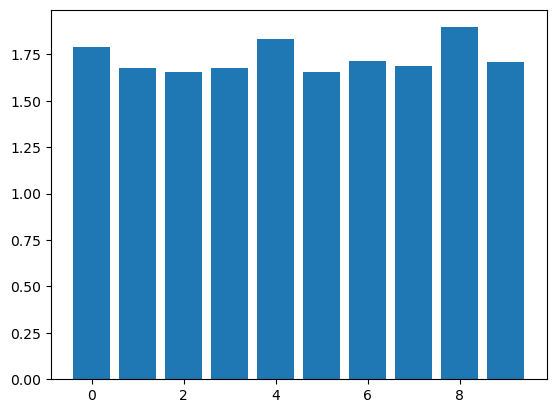

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

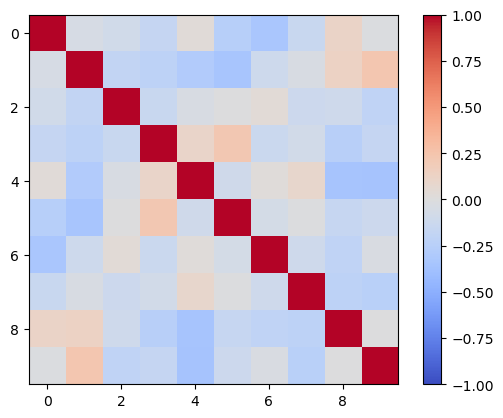

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.9392761, 1: 0.95767283, 2: 0.9506979, 3: 0.9595055, 4: 0.9502206, 5: 0.9533952, 6: 0.9577313, 7: 0.9452783, 8: 0.9587147, 9: 0.9598929}
-------------------VAR-------------------
{0: 0.0018519686, 1: 0.0022043562, 2: 0.0014267624, 3: 0.0010840173, 4: 0.0014289747, 5: 0.0017256, 6: 0.0013224089, 7: 0.001604959, 8: 0.0015677462, 9: 0.0017149318}


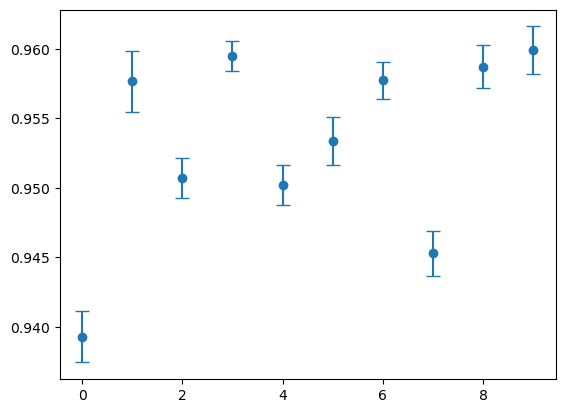

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [3]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([6.5540e-02, 3.1502e-01, 1.1222e-01, 2.1725e-01, 2.3194e-01, 5.2412e-04,
        4.7041e-01, 5.9290e-01, 1.0168e+00, 0.0000e+00, 4.2676e-02, 2.0075e-01,
        8.0820e-01, 1.1252e+00, 1.3919e-01, 9.4035e-01, 3.9450e-01, 9.3562e-01,
        0.0000e+00, 6.0023e-03, 0.0000e+00, 1.0338e+00, 5.3833e-01, 5.9716e-01,
        7.6118e-01, 6.2608e-01, 7.1727e-01, 8.1233e-01, 2.5624e-01, 0.0000e+00,
        1.4312e-03, 1.5028e-01, 1.1923e+00, 2.2950e-01, 5.3986e-01, 0.0000e+00,
        4.7882e-01, 0.0000e+00, 0.0000e+00, 7.5516e-01, 9.3584e-01, 8.0877e-02,
        0.0000e+00, 4.8255e-01, 2.0215e-01, 2.0422e-01, 2.0027e-01, 6.1247e-01,
        1.5262e-03, 8.5732e-01, 0.0000e+00, 3.7193e-01, 2.2477e-01, 7.2094e-01,
        9.9303e-01, 9.2404e-02, 2.2836e-01, 1.3392e+00, 2.8182e-02, 5.8655e-01,
        4.6353e-03, 1.0600e+00, 0.0000e+00, 1.8546e-01, 2.8288e-01, 1.7384e-01,
        9.7657e-01, 1.1502e-03, 2.8599e-

# Cosine Similarity of Centroid Vectors

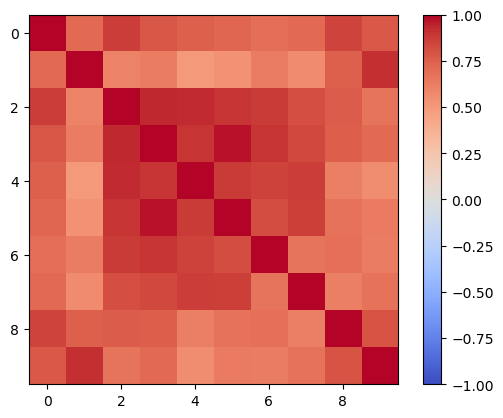

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[1.0000001  0.70509404 0.8723271  0.7826447  0.7468068  0.7219737
  0.69062775 0.70971274 0.84906363 0.77481985]
 [0.70509404 1.         0.6086275  0.6318487  0.49685007 0.537191
  0.6298456  0.5675392  0.7476138  0.90856063]
 [0.8723271  0.6086275  1.         0.9302963  0.9257244  0.8973644
  0.881014   0.81235605 0.75837255 0.66592884]
 [0.7826447  0.6318487  0.9302963  0.9999999  0.8939666  0.97444844
  0.89537054 0.8329973  0.75653094 0.7087628 ]
 [0.7468068  0.49685007 0.9257244  0.8939666  1.         0.8805079
  0.85627794 0.8702447  0.62013113 0.5598173 ]
 [0.7219737  0.537191   0.8973644  0.97444844 0.8805079  1.
  0.8129992  0.8667955  0.67238796 0.63703763]
 [0.69062775 0.6298456  0.881014   0.89537054 0.85627794 0.8129992
  1.0000001  0.6681075  0.6804268  0.62662446]
 [0.70971274 0.5675392  0.81235605 0.8329973  0.8702447  0.8667955
  0.6681075  1.         0.6202197  0.6733572 ]
 [0.84906363 0.7476138  0.75837255 0.75653094 0.62013113 0.67238796
  0

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.4194, 0.5493, 0.2479, 0.2344, 0.3589, 0.3256, 0.3783, 0.4227, 0.4518,
        0.4536], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.4194, 0.5493, 0.2479, 0.2344, 0.3589, 0.3256, 0.3783, 0.4227, 0.4518,
        0.4536], device='cuda:0', grad_fn=<DiagonalBackward0>)


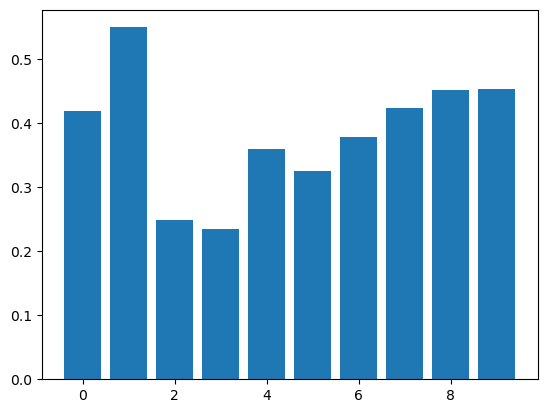

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()